# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("..\data\AirPassengers.csv")
df.set_index('Month', inplace=True)
print('head')
df.head()

head


,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [3]:
df.tail()

,#Passengers
Month,
1960-08,606
1960-09,508
1960-10,461
1960-11,390
1960-12,432


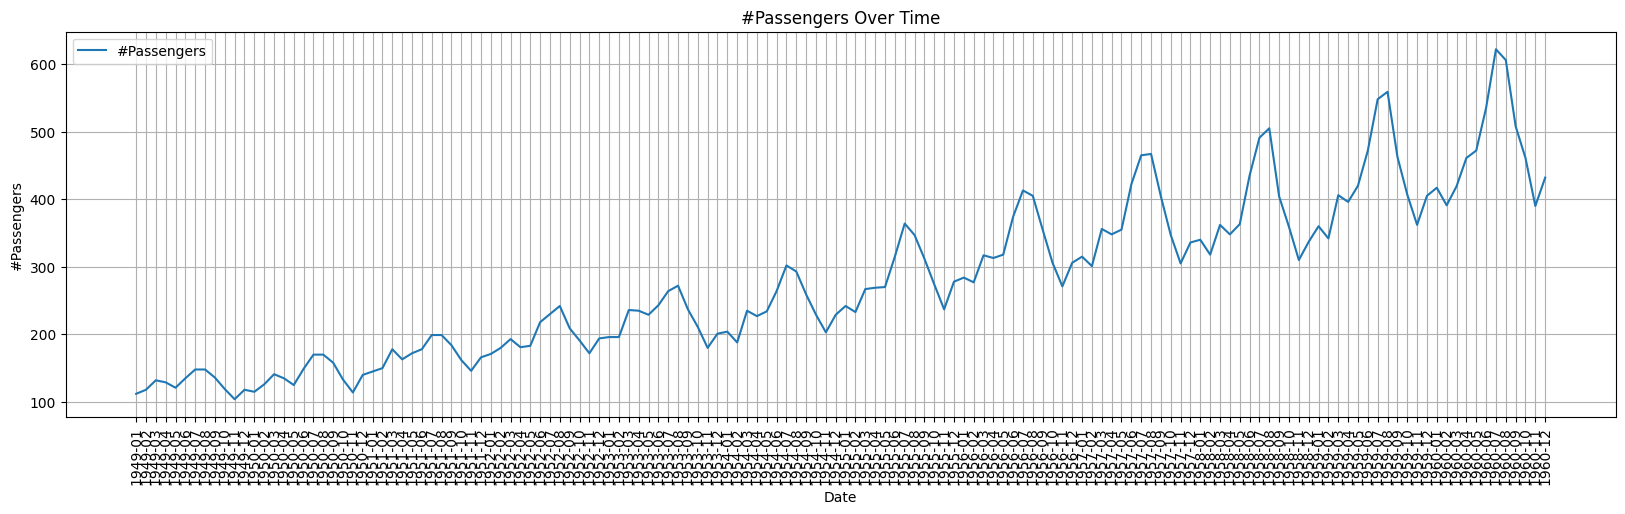

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['#Passengers'], label='#Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.title('#Passengers Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

# Decomposition

In [5]:
# perform seasonal decomposition
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)

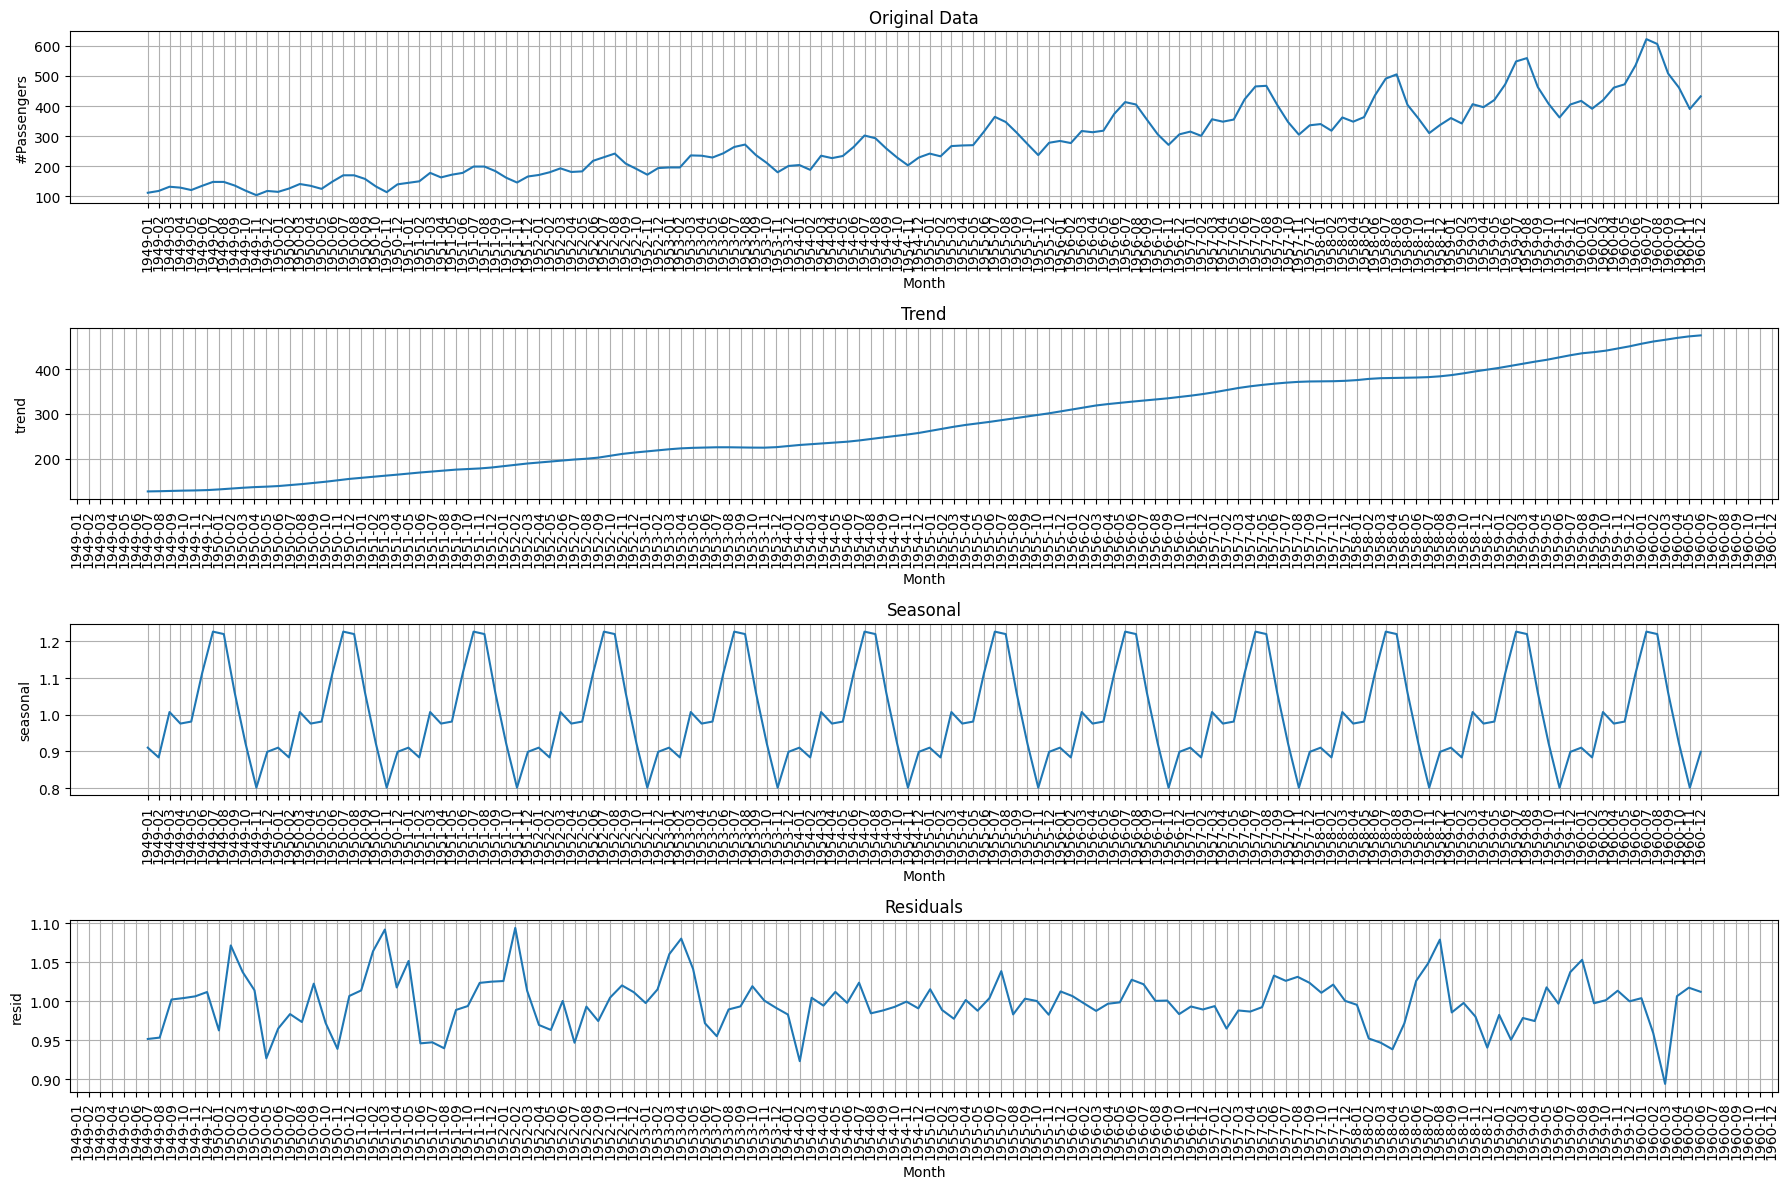

In [6]:
plt.figure(figsize=(18,12))

# Original data
plt.subplot(411)
sns.lineplot(data=df['#Passengers'])
plt.title('Original Data')
plt.xticks(rotation=90)
plt.grid(True) 

# trend component
plt.subplot(412)
sns.lineplot(data=result.trend)
plt.title('Trend')
plt.xticks(rotation=90)
plt.grid(True) 

# seasonal component
plt.subplot(413)
sns.lineplot(data=result.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=90)
plt.grid(True) 

# residuals component
plt.subplot(414)
sns.lineplot(data=result.resid)
plt.title('Residuals')
plt.xticks(rotation=90)
plt.grid(True) 

plt.tight_layout()
plt.show()



# Convert Non Stationary Series to Stationary Series

In [40]:
seasonal_period = 12

In [41]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['#Passengers'], autolag='AIC')
print(result)# Akaike Information Criterion
print('ADF Statistic:', result[0])
print('p-value:', result[1])

(np.float64(0.8153688792060482), np.float64(0.991880243437641), 13, 130, {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}, np.float64(996.692930839019))
ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641


In [42]:
# first order differencing
result = adfuller(df['#Passengers'].diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8292668241699994
p-value: 0.0542132902838255


In [43]:
print(0.05421329028382478<0.05)

False


In [44]:
# second order differencing
result = adfuller(df['#Passengers'].diff().diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -16.384231542468505
p-value: 2.7328918500142407e-29


In [45]:
print(2.7328918500142407e-29<0.05)

True


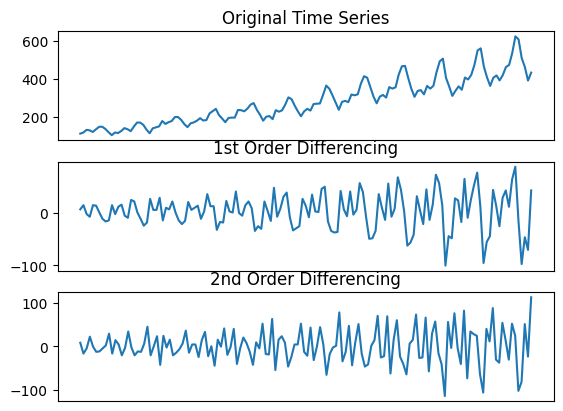

In [46]:
# plot the differencing values
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(df)
ax1.set_title('Original Time Series')
ax1.axes.xaxis.set_visible(False)#hides xlabel

ax2.plot(df.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

ax3.plot(df.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(False)

plt.show()

# ACF and PACF plots

In [47]:
#Original Dataset 
print(df)

         #Passengers
Month               
1949-01          112
1949-02          118
1949-03          132
1949-04          129
1949-05          121
...              ...
1960-08          606
1960-09          508
1960-10          461
1960-11          390
1960-12          432

[144 rows x 1 columns]


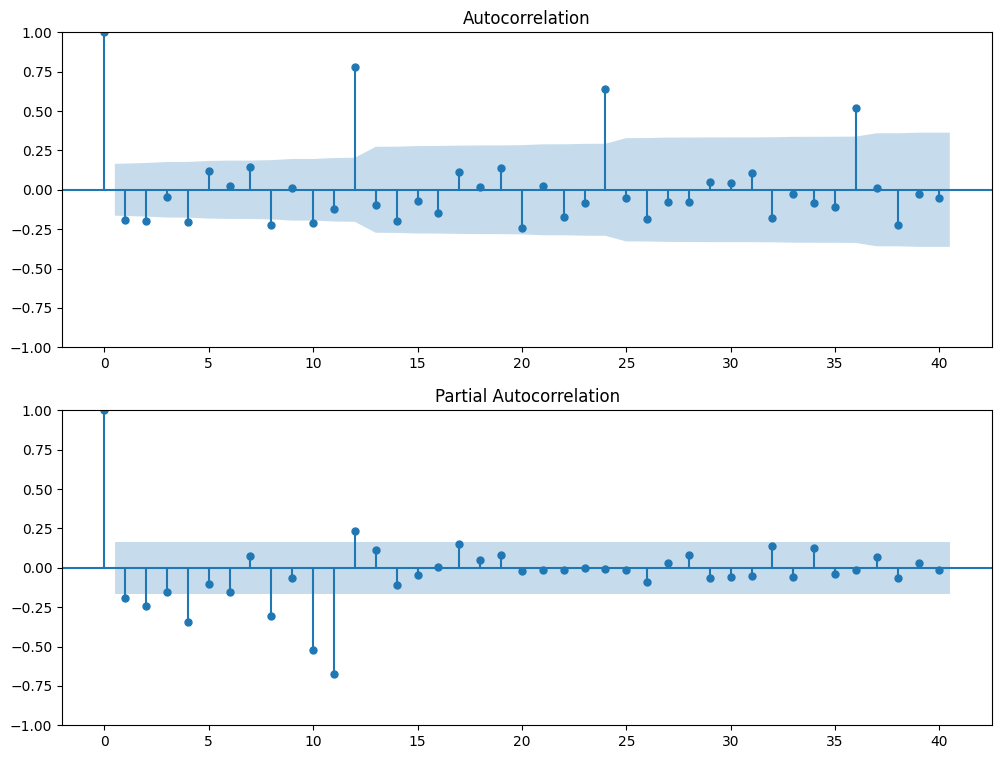

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))
sm.graphics.tsa.plot_acf(df.diff().diff().dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df.diff().diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [49]:
p = 1 # pacf
d = 2 # 2st order difference
q = 1 # acf
P = 1
D = 2
Q = 1

In [50]:
# Assume df['value'] is your original time series
differenced_df = df['#Passengers'].diff().diff().dropna()

## Backtesting

In [52]:
df

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


### Function

In [92]:
df = pd.read_csv("..\data\AirPassengers.csv")
df_prophet=df.copy()
df.set_index('Month', inplace=True)

In [93]:
# Rename the columns for Prophet
df_prophet = df_prophet.rename(
    columns={'Month': 'ds', '#Passengers': 'y'}
)

df_prophet.dtypes

ds    object
y      int64
dtype: object

In [97]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def backtest_time_series(model_type, series, order, seasonal_order=None, train_size_ratio=0.8):
    if model_type == "PROPHET":
        from prophet import Prophet
        # Prophet expects a DataFrame with 'ds' and 'y'
        n = len(series)
        train_size = int(n * train_size_ratio)
        train, test = series.iloc[:train_size], series.iloc[train_size:]
        predictions = []
        for t in range(len(test)):
            hist = series.iloc[:train_size + t]
            m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, changepoint_prior_scale=0.05)
            m.fit(hist)
            future = m.make_future_dataframe(periods=1, freq='MS')
            forecast = m.predict(future)
            yhat = forecast['yhat'].iloc[-1]
            predictions.append(yhat)
        true = test['y'].values
        mse = mean_squared_error(true, predictions)
        mae = mean_absolute_error(true, predictions)
        mape = mean_absolute_percentage_error(true, predictions)
        return test, predictions, mse, mae, mape
    
    n = len(series)
    train_size = int(n * train_size_ratio)
    print(train_size)
    train, test = series[:train_size], series[train_size:]
    predictions = []
    
    
    for t in range(len(test)):
        if model_type == 'AR':
            model = AutoReg(train, lags=order[0]).fit()
            yhat = model.predict(start=len(train), end=len(train), dynamic=False)[0]
        #Forecasting one step ahead: steps=1 tells the model to predict the next value.
        #Extracting the first forecasted value: [0] 
        elif model_type == 'MA':
            model = ARIMA(train, order=order).fit()
            yhat = model.forecast(steps=1)[0]
        elif model_type == 'ARMA':
            model = ARIMA(train, order=order).fit()
            yhat = model.forecast(steps=1)[0]
        elif model_type == 'ARIMA':
            model = ARIMA(train, order=order).fit()
            yhat = model.forecast(steps=1)[0]
        elif model_type == 'SARIMA':
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            yhat = model.forecast(steps=1)[0]
        else:
            raise ValueError("model_type must be 'AR', 'MA', 'ARMA', 'ARIMA', or 'SARIMA'")
        predictions.append(yhat)
        train = np.append(train, test.iloc[t])

    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    return test, predictions, mse, mae, mape

In [99]:
print(df_prophet.head())
# Should show columns: ['ds', 'y']
# 'ds' should be datetime dtype

          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121


### Check for all models

In [79]:
test, predictions, mse, mae, mape = backtest_time_series(
    model_type='AR',
    series=df['#Passengers'],    # your time series
    order=(1,0,0)               # lags=12 for AR(12)
)
print("AR Backtest MSE:", mse, "MAE:", mae, "MAPE: ",mape)

115
AR Backtest MSE: 2794.1346529831635 MAE: 45.18164655913039 MAPE:  0.10308282470523679


In [80]:
test, preds, mse, mae,mape = backtest_time_series(
    model_type='MA',
    series=df['#Passengers'],
    order=(0,0,1)               # q=12 for MA(12)
)
print("MA Backtest MSE:", mse, "MAE:", mae, "MAPE: ",mape)

115
MA Backtest MSE: 11888.575661572759 MAE: 95.66758762635754 MAPE:  0.20973131875111


In [81]:
test, preds, mse, mae,mape = backtest_time_series(
    model_type='ARMA',
    series=df['#Passengers'],
    order=(1, 0, 1)  # ARMA(p,0,q)
)
print("ARMA Backtest MSE:", mse, "MAE:", mae,"MAPE: ",mape)

115
ARMA Backtest MSE: 2453.6344067166156 MAE: 40.88337478629303 MAPE:  0.09394207402681758


In [82]:
test, preds, mse, mae,mape = backtest_time_series(
    model_type='ARIMA',
    series=df['#Passengers'],
    order=(1,1,1)                # ARIMA(p,d,q)
)
print("ARIMA Backtest MSE:", mse, "MAE:", mae,"MAPE: ",mape)

115
ARIMA Backtest MSE: 2483.8027396536168 MAE: 40.58006366354902 MAPE:  0.09413405685820257


In [83]:
test, preds, mse, mae,mape = backtest_time_series(
    model_type='SARIMA',
    series=df['#Passengers'],
    order=(1,1,1),               # (p,d,q)
    seasonal_order=(1,1,1,12)    # (P,D,Q,s)
)
print("SARIMA Backtest MSE:", mse, "MAE:", mae,"MAPE: ",mape)

115
SARIMA Backtest MSE: 304.510014730842 MAE: 13.448151330657371 MAPE:  0.030780442647520254


In [105]:
test, predictions, mse, mae, mape = backtest_time_series(
    model_type='PROPHET',
    series=df_prophet,
    order=None 
)
print("Prophet Backtest MSE:", mse, "MAE:", mae, "MAPE:", mape)

17:40:36 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing
17:40:42 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] done processing
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] done processing
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] done processing
17:40:48 - cmdstanpy - INFO - Chain [1] start processing
17:40:48 - cmdstanpy - INFO - Chain [1] done processing
17:40:48 - cmdstanpy - INFO - Chain [1] start processing
17:40:48 - cmdstanpy - INFO - Chain [1] done processing
17:40:48 - cmdstanpy - INFO - Chain [1] start processing
17:40:48 - cmdstanpy - INFO - Chain [1] done processing
17:40:48 - cmdstanpy - INFO - Chain [1] start processing
17:40:48 - cmdstanpy - INFO - Chain [1] done processing
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1]

Prophet Backtest MSE: 473.4135915739506 MAE: 18.06714178709288 MAPE: 0.040127056934296496


# Forecasting Models

## AR

### Actual Vs Predicted Graph

In [106]:
ar_lag = 1 #p
ar_model_df = AutoReg(df, lags=ar_lag)
ar_fit_df = ar_model_df.fit()
print("\nAR Model Summary:")
print(ar_fit_df.summary())


AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                     AutoReg(1)   Log Likelihood                -704.106
Method:               Conditional MLE   S.D. of innovations             33.277
Date:                Thu, 12 Jun 2025   AIC                           1414.212
Time:                        22:34:22   BIC                           1423.100
Sample:                    02-01-1949   HQIC                          1417.823
                         - 12-01-1960                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.7055      7.084      1.935      0.053      -0.178      27.589
#Passengers.L1     0.9589      0.023     41.106      0.000       0.913       1.005
                 

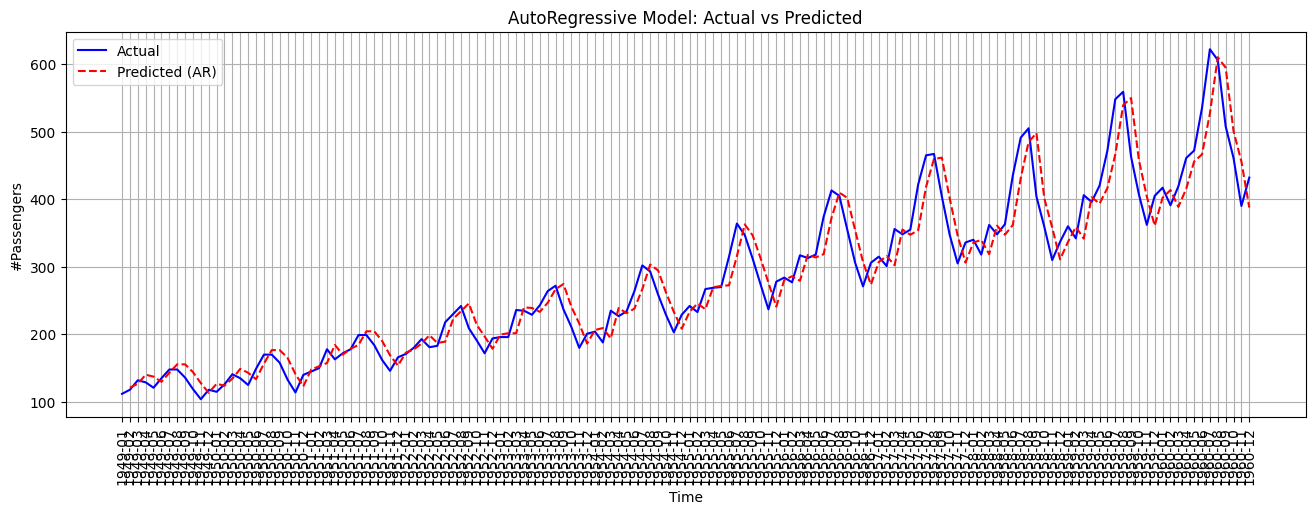

In [107]:
# Make predictions (forecast for the in-sample period)
predictions = ar_fit_df.predict(start=ar_lag, end=len(df)-1)

# Plot actual vs predicted
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['#Passengers'], label='Actual', color='blue')
plt.plot(df.index[ar_lag:], predictions, label='Predicted (AR)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('#Passengers')
plt.xticks(rotation=90)
plt.title('AutoRegressive Model: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
#Look for lower AIC and BIC values

### Forecasting of AR 

In [109]:
ar_lag = 1 #p
ar_model_differenceddf = AutoReg(differenced_df, lags=ar_lag)
ar_fit_differenceddf = ar_model_differenceddf.fit()
print("\nAR Model Summary:")
print(ar_fit_differenceddf.summary())


AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:            #Passengers   No. Observations:                  142
Model:                     AutoReg(1)   Log Likelihood                -716.890
Method:               Conditional MLE   S.D. of innovations             39.071
Date:                Thu, 12 Jun 2025   AIC                           1439.780
Time:                        22:34:28   BIC                           1448.626
Sample:                    04-01-1949   HQIC                          1443.375
                         - 12-01-1960                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0879      3.291      0.027      0.979      -6.362       6.538
#Passengers.L1    -0.2026      0.085     -2.383      0.017      -0.369      -0.036
                 

In [110]:
# Number of steps to forecast
forecast_steps = 24  # for example, next 24 months

# Start and end indices for forecasting
start = len(differenced_df)
end = start + forecast_steps -1

# Forecast the next N differenced values using the fitted AR model
forecast = ar_fit_differenceddf.get_prediction(start=start, end=end, dynamic=False)
print(dir(forecast)) #list all attributes and methods available on the forecast object:
pred_diff = forecast.predicted_mean  # This is a pandas Series of length forecast_steps

# Optional: print the forecasted differenced values
print(pred_diff)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_df', '_predicted_mean', '_row_labels', '_use_pandas', '_var_pred_mean', '_wrap_pandas', 'conf_int', 'dist', 'dist_args', 'predicted_mean', 'row_labels', 'se_mean', 'summary_frame', 't_test', 'tvalues', 'var_pred_mean']
1961-01-01   -22.807509
1961-02-01     4.709067
1961-03-01    -0.866191
1961-04-01     0.263437
1961-05-01     0.034558
1961-06-01     0.080932
1961-07-01     0.071536
1961-08-01     0.073440
1961-09-01     0.073054
1961-10-01     0.073132
1961-11-01     0.073116
1961-12-01     0.073119
1962-01-01     0.073119
1962-02-01     0.073119
1962-03-01     0.073119
1962-04-01     0.073119
1962-05-01     0.073119
1962-06-01

In [111]:
last_value = df['#Passengers'].iloc[-1]
second_last_value = df['#Passengers'].iloc[-2]

In [112]:
forecast_values = []
for i, diff_val in enumerate(pred_diff):
    if i == 0:
        next_value = diff_val + (last_value - second_last_value) + last_value
    elif i == 1:
        next_value = diff_val + (next_value - last_value) + next_value
    else:
        next_value = diff_val + 2 * forecast_values[-1] - forecast_values[-2]
    forecast_values.append(next_value)

In [113]:
forecast_index = pd.date_range(
    start=pd.to_datetime(df.index)[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_steps,
    freq='MS'
)

In [114]:
forecast_df = pd.DataFrame({'Forecast': forecast_values}, index=forecast_index)

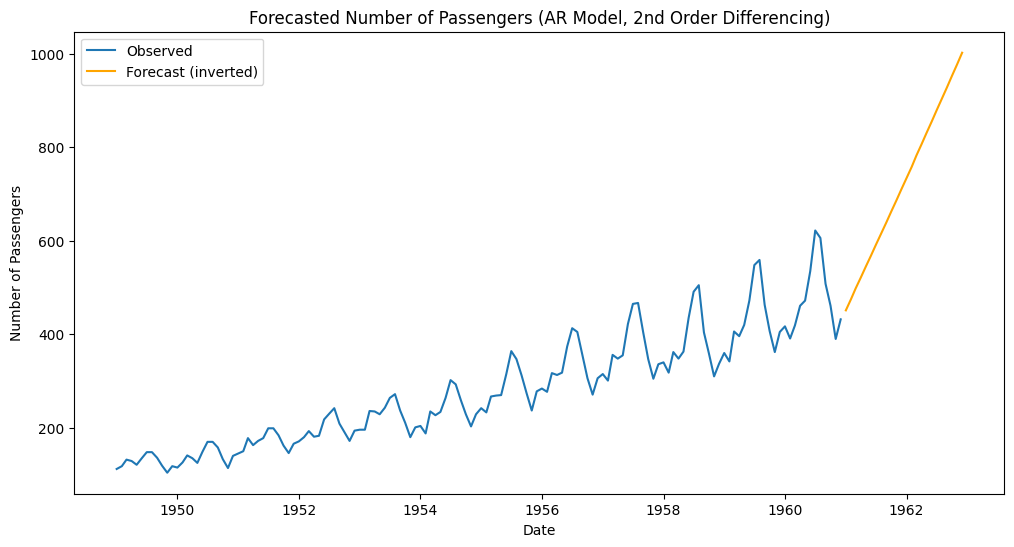

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df.index), df['#Passengers'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (inverted)', color='orange')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.title('Forecasted Number of Passengers (AR Model, 2nd Order Differencing)')
plt.show()

## MA

In [116]:
ma_order = 1

### Actual Vs Predicted Graph

In [117]:

ma_model = ARIMA(df['#Passengers'], order=(0, 0, ma_order))
ma_fit = ma_model.fit()
print("\nMA Model Summary:")
print(ma_fit.summary())


MA Model Summary:
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -806.431
Date:                Thu, 12 Jun 2025   AIC                           1618.863
Time:                        22:34:40   BIC                           1627.772
Sample:                    01-01-1949   HQIC                          1622.483
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.6521     11.648     24.094      0.000     257.822     303.482
ma.L1          0.9642      0.030     32.205      0.000       0.906       1.023
sigma2      4205.0752    586.678 

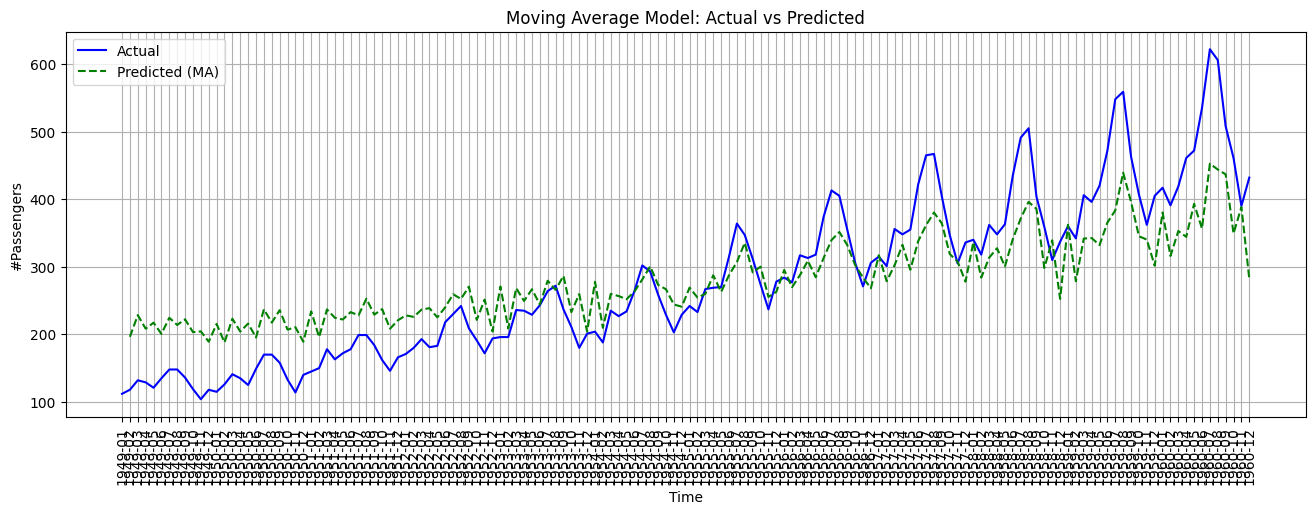

In [118]:
# In-sample predictions
ma_pred = ma_fit.predict(start=1, end=len(df)-1)

# Plot
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['#Passengers'], label='Actual', color='blue')
plt.plot(df.index[1:], ma_pred, label='Predicted (MA)', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('#Passengers')
plt.xticks(rotation=90)
plt.title('Moving Average Model: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

### Forecasting of MA

In [119]:
ma_model = ARIMA(differenced_df, order=(0, 0, ma_order))
ma_fit = ma_model.fit()
print("\nMA Model Summary:")
print(ma_fit.summary())


MA Model Summary:
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  142
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -703.681
Date:                Thu, 12 Jun 2025   AIC                           1413.363
Time:                        22:34:41   BIC                           1422.230
Sample:                    03-01-1949   HQIC                          1416.966
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.071     -0.069      0.945      -0.145       0.135
ma.L1         -0.9999      4.612     -0.217      0.828     -10.039       8.040
sigma2      1139.4559   5271.853 

In [120]:
# --- 4. Forecast future differenced values ---
forecast_steps = 24
start = len(differenced_df)
end = start + forecast_steps - 1

forecast = ma_fit.get_prediction(start=start, end=end, dynamic=False)
pred_diff = forecast.predicted_mean
print("\nPredicted differenced values:")
print(pred_diff)


Predicted differenced values:
1961-01-01   -40.115538
1961-02-01    -0.004907
1961-03-01    -0.004907
1961-04-01    -0.004907
1961-05-01    -0.004907
1961-06-01    -0.004907
1961-07-01    -0.004907
1961-08-01    -0.004907
1961-09-01    -0.004907
1961-10-01    -0.004907
1961-11-01    -0.004907
1961-12-01    -0.004907
1962-01-01    -0.004907
1962-02-01    -0.004907
1962-03-01    -0.004907
1962-04-01    -0.004907
1962-05-01    -0.004907
1962-06-01    -0.004907
1962-07-01    -0.004907
1962-08-01    -0.004907
1962-09-01    -0.004907
1962-10-01    -0.004907
1962-11-01    -0.004907
1962-12-01    -0.004907
Freq: MS, Name: predicted_mean, dtype: float64


In [121]:
last_value = df['#Passengers'].iloc[-1]
second_last_value = df['#Passengers'].iloc[-2]
forecast_values = []
for i, diff_val in enumerate(pred_diff):
    if i == 0:
        next_value = diff_val + (last_value - second_last_value) + last_value
    elif i == 1:
        next_value = diff_val + (next_value - last_value) + next_value
    else:
        next_value = diff_val + 2 * forecast_values[-1] - forecast_values[-2]
    forecast_values.append(next_value)

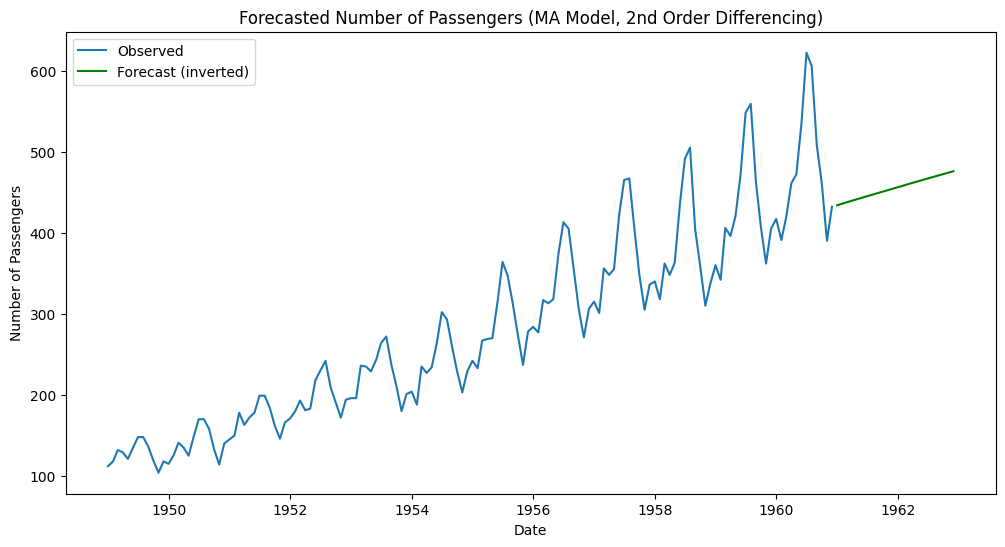

In [122]:
forecast_index = pd.date_range(
    start=pd.to_datetime(df.index)[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_steps,
    freq='MS'
)
forecast_df = pd.DataFrame({'Forecast': forecast_values}, index=forecast_index)

# --- 7. Plot observed and forecasted values ---
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df.index), df['#Passengers'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (inverted)', color='green')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.title('Forecasted Number of Passengers (MA Model, 2nd Order Differencing)')
plt.show()

## ARMA

In [123]:
arma_order = (1, 0, 1)

### Actual vs Predicted Graph

In [124]:
arma_model = ARIMA(df['#Passengers'], order=arma_order)
arma_fit = arma_model.fit()
print("\nARMA Model Summary:")
print(arma_fit.summary())


ARMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -700.874
Date:                Thu, 12 Jun 2025   AIC                           1409.749
Time:                        22:34:42   BIC                           1421.628
Sample:                    01-01-1949   HQIC                          1414.576
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3009     56.644      4.948      0.000     169.281     391.321
ar.L1          0.9373      0.028     34.009      0.000       0.883       0.991
ma.L1          0.4264      0.07

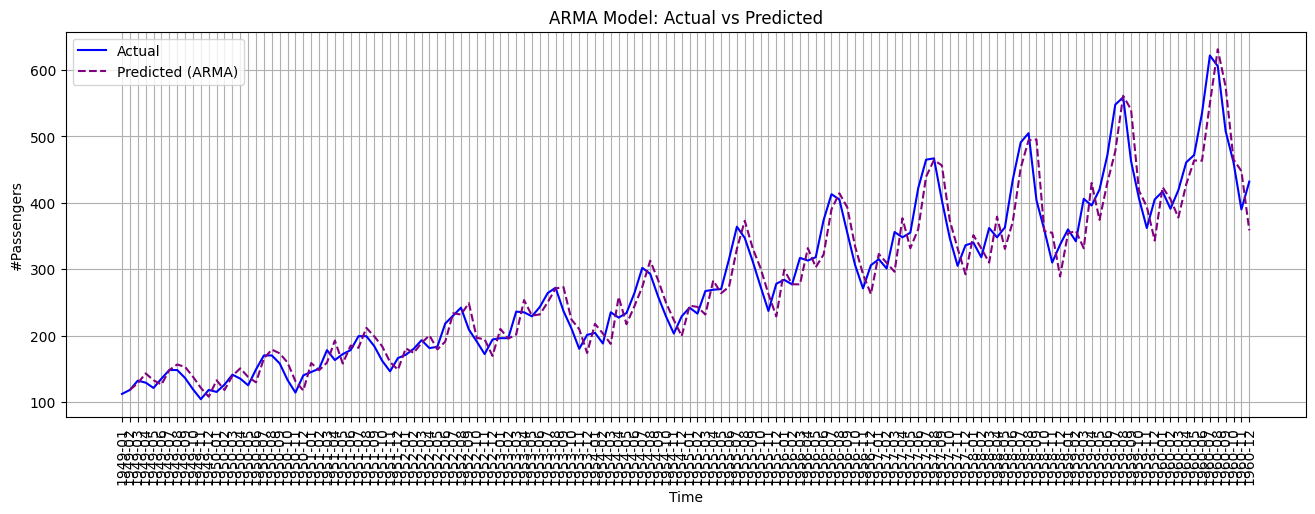

In [125]:
# In-sample predictions
arma_pred = arma_fit.predict(start=1, end=len(df)-1)

# Plot
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['#Passengers'], label='Actual', color='blue')
plt.plot(df.index[1:], arma_pred, label='Predicted (ARMA)', color='purple', linestyle='--')
plt.xlabel('Time')
plt.ylabel('#Passengers')
plt.xticks(rotation=90)
plt.title('ARMA Model: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

### Forecast for ARMA

In [126]:
arma_model = ARIMA(differenced_df, order=(arma_order))
arma_fit = arma_model.fit()
print("\nARMA Model Summary:")
print(arma_fit.summary())


ARMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  142
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -696.465
Date:                Thu, 12 Jun 2025   AIC                           1400.929
Time:                        22:34:43   BIC                           1412.753
Sample:                    03-01-1949   HQIC                          1405.734
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.642e-05      0.104     -0.000      1.000      -0.204       0.204
ar.L1          0.3131      0.126      2.481      0.013       0.066       0.560
ma.L1         -0.9999     23.70

In [127]:
# --- 4. Forecast future differenced values ---
forecast_steps = 24
start = len(differenced_df)
end = start + forecast_steps - 1

forecast = arma_fit.get_prediction(start=start, end=end, dynamic=False)
pred_diff = forecast.predicted_mean
print("\nPredicted differenced values:")
print(pred_diff)


Predicted differenced values:
1961-01-01   -27.219886
1961-02-01    -8.522514
1961-03-01    -2.668406
1961-04-01    -0.835497
1961-05-01    -0.261617
1961-06-01    -0.081937
1961-07-01    -0.025679
1961-08-01    -0.008065
1961-09-01    -0.002550
1961-10-01    -0.000823
1961-11-01    -0.000283
1961-12-01    -0.000114
1962-01-01    -0.000061
1962-02-01    -0.000044
1962-03-01    -0.000039
1962-04-01    -0.000037
1962-05-01    -0.000037
1962-06-01    -0.000036
1962-07-01    -0.000036
1962-08-01    -0.000036
1962-09-01    -0.000036
1962-10-01    -0.000036
1962-11-01    -0.000036
1962-12-01    -0.000036
Freq: MS, Name: predicted_mean, dtype: float64


In [128]:
# --- 5. Invert differencing to get original scale forecast ---
last_value = df['#Passengers'].iloc[-1]
second_last_value = df['#Passengers'].iloc[-2]
forecast_values = []
for i, diff_val in enumerate(pred_diff):
    if i == 0:
        next_value = diff_val + (last_value - second_last_value) + last_value
    elif i == 1:
        next_value = diff_val + (next_value - last_value) + next_value
    else:
        next_value = diff_val + 2 * forecast_values[-1] - forecast_values[-2]
    forecast_values.append(next_value)



In [129]:
# --- 6. Create forecast index ---
forecast_index = pd.date_range(
    start=pd.to_datetime(df.index)[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_steps,
    freq='MS'
)
forecast_df = pd.DataFrame({'Forecast': forecast_values}, index=forecast_index)



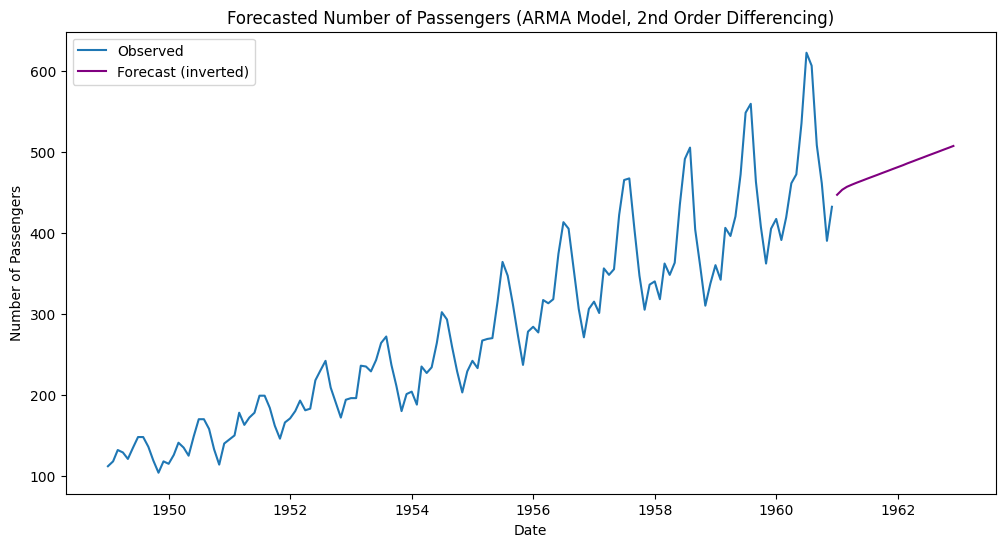

In [130]:
# --- 7. Plot observed and forecasted values ---
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df.index), df['#Passengers'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (inverted)', color='purple')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.title('Forecasted Number of Passengers (ARMA Model, 2nd Order Differencing)')
plt.show()

## ARIMA

In [131]:
arima_order = (1, 2, 1)

### Actual vs Predicted

In [132]:
arima_model = ARIMA(df['#Passengers'], order=arima_order)
arima_fit = arima_model.fit()
print("\nARIMA Model Summary:")
print(arima_fit.summary())


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -696.464
Date:                Thu, 12 Jun 2025   AIC                           1398.928
Time:                        22:34:43   BIC                           1407.796
Sample:                    01-01-1949   HQIC                          1402.532
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3130      0.100      3.127      0.002       0.117       0.509
ma.L1         -0.9998      5.966     -0.168      0.867     -12.693      10.693
sigma2      1034.0044   6208.0

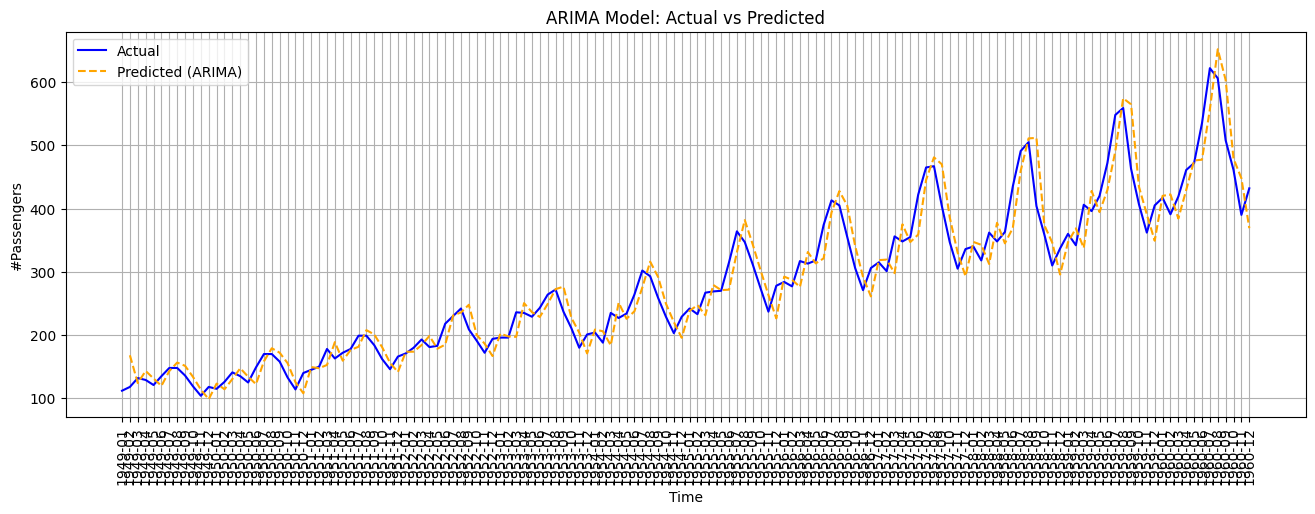

In [133]:
# In-sample predictions (note start=1 due to differencing)
arima_pred = arima_fit.predict(start=1, end=len(df)-1, typ='levels')

# Plot
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['#Passengers'], label='Actual', color='blue')
plt.plot(df.index[1:], arima_pred, label='Predicted (ARIMA)', color='orange', linestyle='--')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('#Passengers')
plt.title('ARIMA Model: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

### Forecasting of ARIMA

In [134]:
arima_model = ARIMA(df['#Passengers'], order=arima_order)
arima_fit = arima_model.fit()
print("\nARIMA Model Summary:")
print(arima_fit.summary())


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -696.464
Date:                Thu, 12 Jun 2025   AIC                           1398.928
Time:                        22:34:46   BIC                           1407.796
Sample:                    01-01-1949   HQIC                          1402.532
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3130      0.100      3.127      0.002       0.117       0.509
ma.L1         -0.9998      5.966     -0.168      0.867     -12.693      10.693
sigma2      1034.0044   6208.0

In [135]:
# --- 4. Forecast future values ---
forecast_steps = 24
forecast = arima_fit.get_prediction(start=len(df), end=len(df) + forecast_steps - 1, dynamic=False)
forecast_mean = forecast.predicted_mean
print("\nForecasted values:")
print(forecast_mean)




Forecasted values:
1961-01-01    446.777028
1961-02-01    453.034436
1961-03-01    456.625570
1961-04-01    459.382275
1961-05-01    461.877839
1961-06-01    464.291677
1961-07-01    466.679938
1961-08-01    469.060196
1961-09-01    471.437948
1961-10-01    473.814916
1961-11-01    476.191639
1961-12-01    478.568285
1962-01-01    480.944907
1962-02-01    483.321522
1962-03-01    485.698134
1962-04-01    488.074746
1962-05-01    490.451357
1962-06-01    492.827968
1962-07-01    495.204579
1962-08-01    497.581190
1962-09-01    499.957802
1962-10-01    502.334413
1962-11-01    504.711024
1962-12-01    507.087635
Freq: MS, Name: predicted_mean, dtype: float64


In [136]:
# --- 5. Create forecast index ---
forecast_index = pd.date_range(
    start=pd.to_datetime(df.index)[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_steps,
    freq='MS'
)
forecast_df = pd.DataFrame({'Forecast': forecast_mean.values}, index=forecast_index)



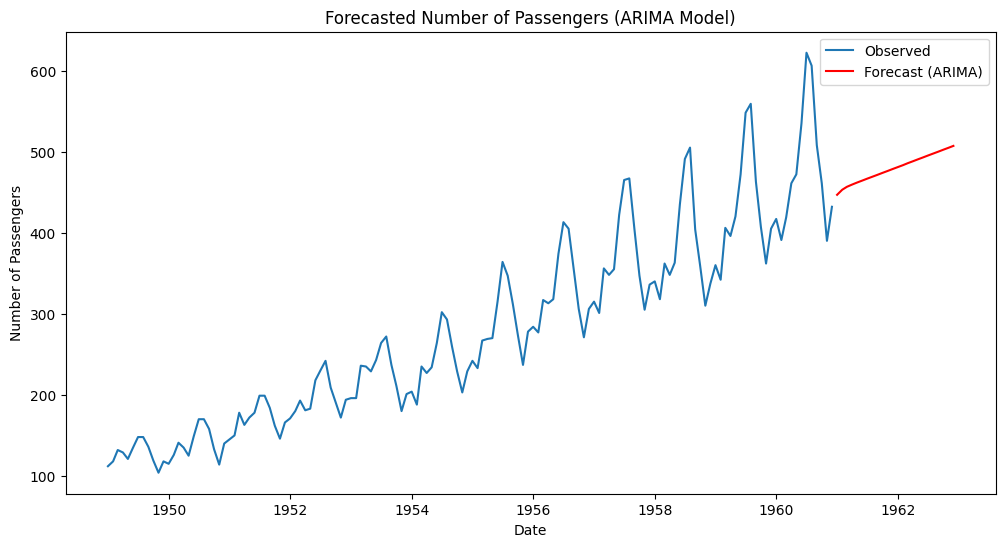

In [137]:
# --- 6. Plot observed and forecasted values ---
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df.index), df['#Passengers'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast (ARIMA)', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.title('Forecasted Number of Passengers (ARIMA Model)')
plt.show()

## SARIMA

### Actual vs Predicted Graph

In [138]:
seasonal_period = 12

In [139]:
# define the sarima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['#Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
fitted_model = model.fit()
print(fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 12)   Log Likelihood                -467.460
Date:                            Thu, 12 Jun 2025   AIC                            944.920
Time:                                    22:34:50   BIC                            958.774
Sample:                                01-01-1949   HQIC                           950.545
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4158      0.081     -5.108      0.000      -0.575      -0.256
ma.L1         -0.9997      7.526   

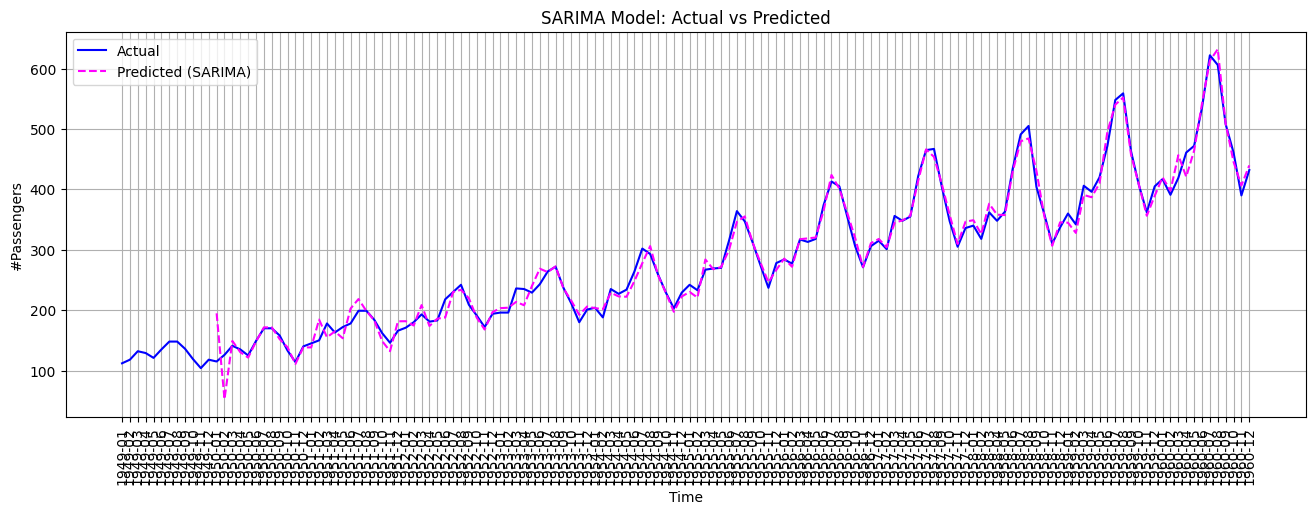

In [140]:
sarima_pred = fitted_model.predict(start=seasonal_period, end=len(df)-1, dynamic=False)

# Plot actual vs predicted
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['#Passengers'], label='Actual', color='blue')
plt.plot(df.index[seasonal_period:], sarima_pred, label='Predicted (SARIMA)', color='magenta', linestyle='--')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('#Passengers')
plt.title('SARIMA Model: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

### Forecating for next 2 years

In [141]:
# 1. Make sure your df index is a DatetimeIndex
df.index = pd.to_datetime(df.index)

In [142]:
# 2. Forecast setup (as you have)
forecast_steps = 3
forecast = fitted_model.get_forecast(steps=forecast_steps)

# 3. Make forecast_index a DatetimeIndex (no strftime!)
forecast_index = pd.date_range(
    start=df.index[-1] + pd.offsets.MonthEnd(1),  # next month after last value
    periods=forecast_steps,
    freq='M'
)

In [143]:
# 4. Create forecast_df with DatetimeIndex
forecast_df = pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI": list(forecast.conf_int().iloc[:, 0]),
    "Upper CI": list(forecast.conf_int().iloc[:, 1])
}, index=forecast_index)

In [145]:
forecast_df

,Forecast,Lower CI,Upper CI
1960-12-31,448.476925,426.525541,470.428309
1961-01-31,420.852410,395.169361,446.535458
1961-02-28,462.028140,430.987708,493.068572


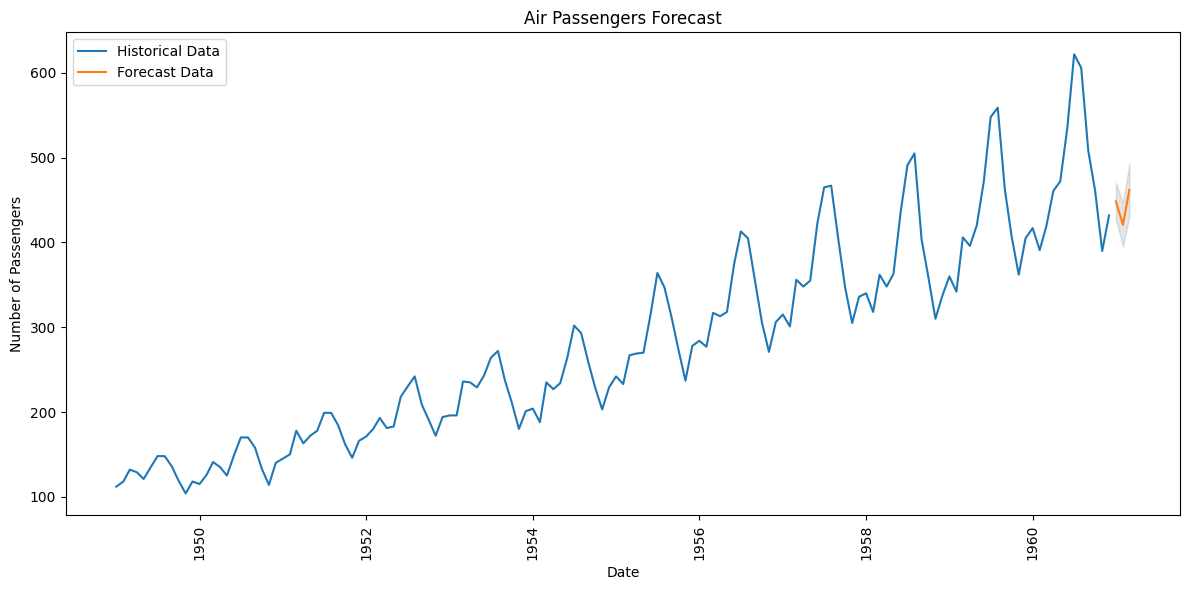

In [146]:
# 5. Plot with 2-year x-axis ticks
plt.figure(figsize=(12, 6))
plt.plot(df['#Passengers'], label='Historical Data')
plt.plot(forecast_df['Forecast'], label='Forecast Data')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers Forecast')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # Tick every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as 'YYYY', or use '%m-%Y' for months/years
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Prophet 

In [147]:
from prophet import Prophet

In [148]:
df = df.reset_index() # Month becomes a column


In [149]:
# Rename the columns for Prophet
df = df.rename(
    columns={'Month': 'ds', '#Passengers': 'y'}
)

# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Now it is ready for Prophet
print(df.head())

          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121


In [150]:
print(df.dtypes)


ds    datetime64[ns]
y              int64
dtype: object


In [151]:
model = Prophet()
model.fit(df)

22:36:15 - cmdstanpy - INFO - Chain [1] start processing
22:36:19 - cmdstanpy - INFO - Chain [1] done processing


In [164]:
future = model.make_future_dataframe(periods=3, freq='MS')
forecast = model.predict(future)

In [165]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


            ds        yhat  yhat_lower  yhat_upper
142 1960-11-01  421.955303  391.423549  451.963044
143 1960-12-01  451.174702  422.844322  483.037313
144 1961-01-01  465.855759  435.992538  493.755344
145 1961-02-01  460.213899  430.798075  487.936656
146 1961-03-01  493.181183  465.452829  520.370397


In [166]:
# Set display options
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap lines
pd.set_option('display.max_colwidth', None) # Show full column content

In [167]:
print(forecast)

            ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1949-01-01  106.662426   56.507209  114.352450   106.662426   106.662426   
1   1949-02-01  108.835452   50.057967  106.213928   108.835452   108.835452   
2   1949-03-01  110.798186   82.374866  139.406270   110.798186   110.798186   
3   1949-04-01  112.971212   76.412042  137.052686   112.971212   112.971212   
4   1949-05-01  115.074141   83.262720  139.363198   115.074141   115.074141   
5   1949-06-01  117.247168  124.564186  179.635998   117.247168   117.247168   
6   1949-07-01  119.350097  161.298524  218.800467   119.350097   119.350097   
7   1949-08-01  121.523123  158.970895  218.991918   121.523123   121.523123   
8   1949-09-01  123.696149  112.189982  168.678339   123.696149   123.696149   
9   1949-10-01  125.799078   75.874374  131.853964   125.799078   125.799078   
10  1949-11-01  127.972105   40.451054   95.294967   127.972105   127.972105   
11  1949-12-01  130.075034   70.775538  

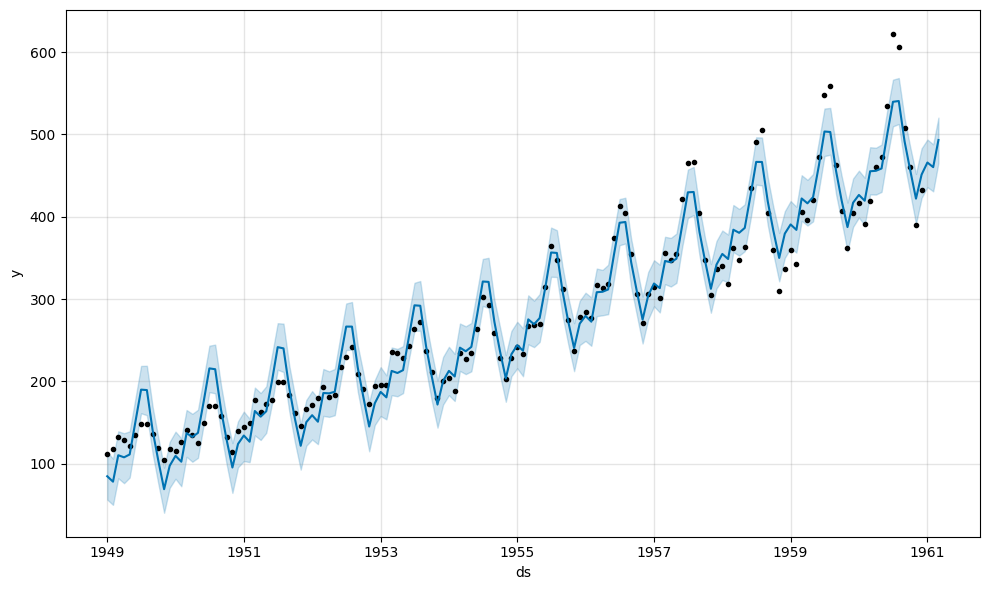

In [168]:
import matplotlib.pyplot as plt

fig1 = model.plot(forecast)
plt.show()

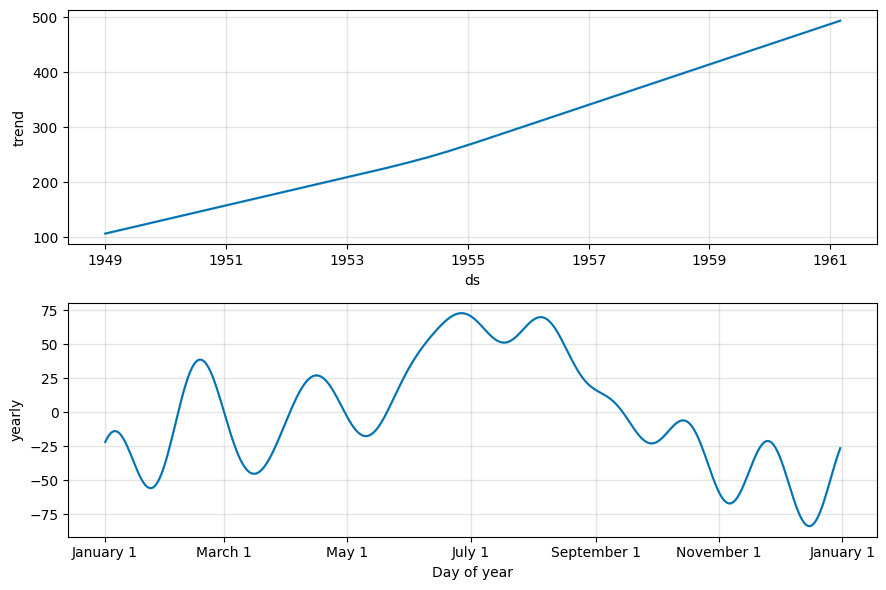

In [169]:
fig2 = model.plot_components(forecast)
plt.show()